In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from resnet import ResNet, ResNet50

In [12]:
import pickle

In [22]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=transform_test)
testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

In [14]:
meta_path = "./data/cifar-100-python/meta"
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)

In [17]:
classes = meta['fine_label_names']
len(classes)

100

In [18]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [24]:
epoch_200_net = ResNet50(100)
epoch_200_net.load_state_dict(torch.load('./models/epoch_200.pth', weights_only=True))
epoch_200_net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (i_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, m

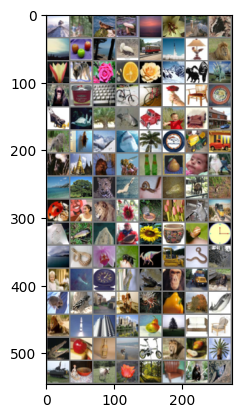

GroundTruth:  mountain forest seal mushroom sea tulip camel butterfly cloud apple sea skunk streetcar rocket lamp lion tulip wolf rose orange rose mountain skunk dinosaur chimpanzee can keyboard bicycle bicycle rose chair plate lawn_mower turtle palm_tree shark pickup_truck boy couch house porcupine cockroach mountain shark palm_tree clock lawn_mower pickup_truck skunk castle beaver bee bottle pear baby flatfish sea oak_tree leopard rocket snail crocodile camel rabbit beetle girl lion sunflower porcupine tulip raccoon train ray trout flatfish flatfish sunflower bowl snail clock sea snake orchid bee dinosaur tractor snake forest boy ray clock caterpillar crocodile chimpanzee bus chimpanzee mouse skunk house girl crab sweet_pepper maple_tree whale lion rocket skyscraper castle pear pine_tree couch chair crocodile apple bottle sea bicycle lion pear palm_tree tank bowl cattle tulip forest chair chimpanzee mouse
Predicted:  man forest dolphin mushroom sea bee tiger butterfly cloud pear tele

In [27]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

imshow(torchvision.utils.make_grid(images.cpu()))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(128)))
outputs = epoch_200_net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]] for j in range(128)))

In [28]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = epoch_200_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


In [29]:
train = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=transform_test)
trainloader = torch.utils.data.DataLoader(train, batch_size=128,shuffle=False, num_workers=2)

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = epoch_200_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 50000 train images: 86 %


In [31]:
criterion = nn.CrossEntropyLoss()

In [ ]:
def get_regularized_curvature_for_batch(net, batch_data, batch_labels, h=1e-3, niter=10, temp=1):
    num_samples = batch_data.shape[0]
    net.eval()
    net.zero_grad()
    regr = torch.zeros(num_samples)
    eigs = torch.zeros(num_samples)
    for _ in range(niter):
        v = torch.randint_like(batch_data, high=2).cuda()
        # Generate Rademacher random variables
        for v_i in v:
            v_i[v_i == 0] = -1

        v = h * (v + 1e-7)

        batch_data.requires_grad_()
        outputs_pos = net(batch_data + v)
        outputs_orig = net(batch_data)
        loss_pos = criterion(outputs_pos / temp, batch_labels)
        loss_orig = criterion(outputs_orig / temp, batch_labels)
        grad_diff = torch.autograd.grad((loss_pos-loss_orig), batch_data )[0]

        regr += grad_diff.reshape(grad_diff.size(0), -1).norm(dim=1).cpu().detach()
        eigs += torch.diag(torch.matmul(v.reshape(num_samples,-1), grad_diff.reshape(num_samples,-1).T)).cpu().detach()
        net.zero_grad()
        if batch_data.grad is not None:
            batch_data.grad.zero_()

    eig_estimate = eigs / niter
    curv_estimate = regr / niter
    return eig_estimate, curv_estimate

In [39]:
epoch_50_net = ResNet50(100)
epoch_50_net.load_state_dict(torch.load('./models/epoch_50.pth', weights_only=True))
epoch_50_net.to(device)
epoch_50_path = './curv_scores/epoch_50'

In [38]:
def save_curv_scores_for_net(net, path):
    scores = torch.zeros(len(train))
    eig_score = torch.zeros_like(scores)
    labels = torch.zeros_like(scores, dtype=torch.long)
    total = 0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        start_idx = total
        stop_idx = total + len(targets)
        idxs = [j for j in range(start_idx, stop_idx)]
        total = stop_idx

        inputs.requires_grad = True

        eig_estimate, curv_estimate = get_regularized_curvature_for_batch(net, inputs, targets)
        scores[idxs] = curv_estimate.detach().clone().cpu()
        eig_score[idxs] = eig_estimate.detach().clone().cpu()
        labels[idxs] = targets.cpu().detach()

    torch.save(scores, f'{path}/scores.pt')
    torch.save(eig_score, f'{path}/eig_score.pt')
    torch.save(labels, f'{path}/labels.pt')

In [40]:
save_curv_scores_for_net(epoch_50_net, epoch_50_path)

In [41]:
epoch_100_net = ResNet50(100)
epoch_100_net.load_state_dict(torch.load('./models/epoch_100.pth', weights_only=True))
epoch_100_net.to(device)
epoch_100_path = './curv_scores/epoch_100'

save_curv_scores_for_net(epoch_100_net, epoch_100_path)

In [42]:
epoch_150_net = ResNet50(100)
epoch_150_net.load_state_dict(torch.load('./models/epoch_150.pth', weights_only=True))
epoch_150_net.to(device)
epoch_150_path = './curv_scores/epoch_150'

save_curv_scores_for_net(epoch_150_net, epoch_150_path)